<a href="https://colab.research.google.com/github/ahmedSadoun/colab-project/blob/main/inceptionresnetv2skincancertpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.72.193.234:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.72.193.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.193.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:49<00:00, 25.0MB/s]
100% 5.20G/5.20G [01:49<00:00, 51.1MB/s]


In [ ]:
import zipfile
zf = "/content/skin-cancer-mnist-ham10000.zip"
target_dir = "/content/skin-cancer-mnist"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils

import itertools

import cv2
from PIL import Image

In [ ]:
base_skin_dir = os.path.join('..', "/content/skin-cancer-mnist/")

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist/HAM10000_images_par...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist/HAM10000_images_par...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist/HAM10000_images_par...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/skin-cancer-mnist/HAM10000_images_par...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/skin-cancer-mnist/ham10000_images_par...,Benign keratosis-like lesions,2


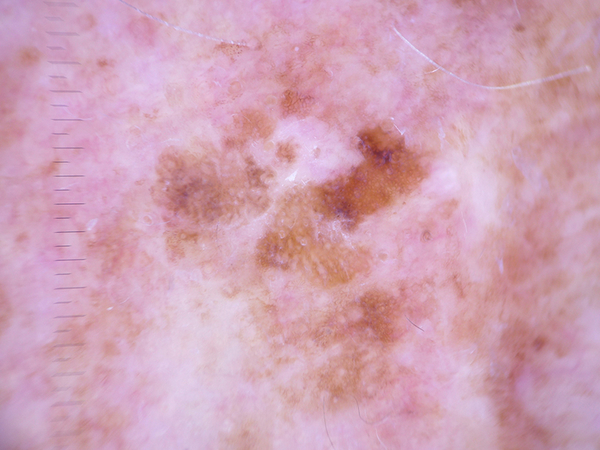

In [ ]:
Image.open('/content/skin-cancer-mnist/HAM10000_images_part_1/ISIC_0027419.jpg')

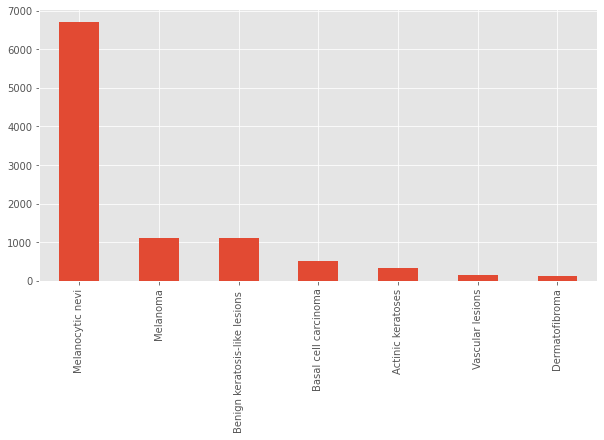

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
data['cell_type'].value_counts() < 1000

Melanocytic nevi                  False
Melanoma                          False
Benign keratosis-like lesions     False
Basal cell carcinoma               True
Actinic keratoses                  True
Vascular lesions                   True
Dermatofibroma                     True
Name: cell_type, dtype: bool

In [ ]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=7000,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

In [ ]:
def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values
imgs, target   = load_img_data(128, data, balanced=False)

100%|██████████| 10015/10015 [01:32<00:00, 108.05it/s]


(10015, 128, 128, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(9514, 128, 128, 3), (501, 128, 128, 3), (2003, 128, 128, 3)]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               8389120   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

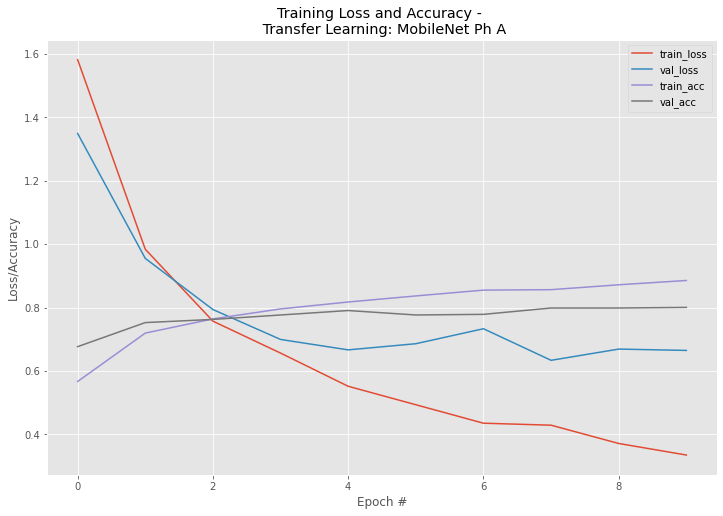


Phase B  - Fine Tune all Layers 

Epoch 1/10
74/74 [==============================] - 22s 255ms/step - loss: 1.6321 - accuracy: 0.6538 - val_loss: 0.9536 - val_accuracy: 0.7285

Epoch 00001: val_loss improved from inf to 0.95363, saving model to MobileNet_ph2_weights.hdf5
Epoch 2/10
74/74 [==============================] - 18s 240ms/step - loss: 1.2635 - accuracy: 0.6947 - val_loss: 1.0212 - val_accuracy: 0.7126

Epoch 00002: val_loss did not improve from 0.95363
Epoch 3/10
74/74 [==============================] - 18s 238ms/step - loss: 1.0539 - accuracy: 0.7276 - val_loss: 0.9565 - val_accuracy: 0.7345

Epoch 00003: val_loss did not improve from 0.95363
Epoch 4/10
74/74 [==============================] - 18s 244ms/step - loss: 0.9486 - accuracy: 0.7387 - val_loss: 0.9207 - val_accuracy: 0.7345

Epoch 00004: val_loss improved from 0.95363 to 0.92070, saving model to MobileNet_ph2_weights.hdf5
Epoch 5/10
74/74 [==============================] - 18s 242ms/step - loss: 0.8565 - accuracy:

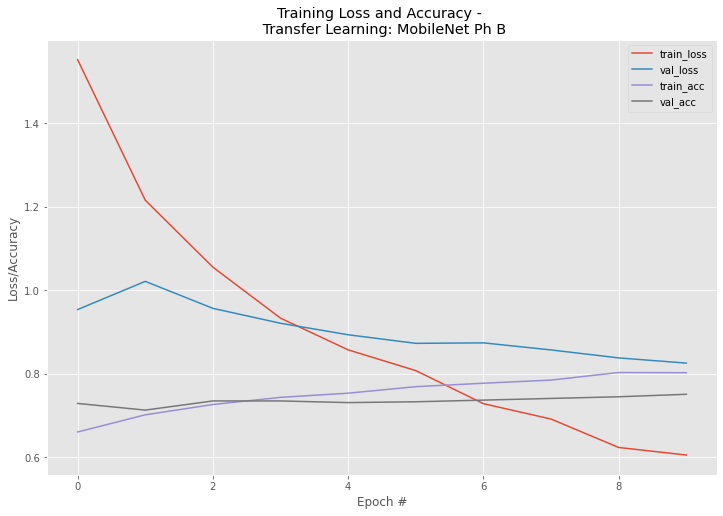

In [ ]:
class Tuner(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNetV2':
            nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionResNetV2':
            nn= tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,
                                                            input_shape=self.input_shape, 
                                                            weights='imagenet'
                                                            )

        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()
        #self.load_weights(self.best_weights)
        #self.predict()

    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model

    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        #print('\nData augmentation with the following parameters:')
        #pp.pprint(data_gen_args)

        return train_generator

    def get_class_weight(self):

        weight_for_0 = (1 / (self.trainY == 0).sum())*(len(self.trainY))/7.0 
        weight_for_1 = (1 / (self.trainY == 1).sum())*(len(self.trainY))/7.0
        weight_for_2 = (1 / (self.trainY == 2).sum())*(len(self.trainY))/7.0 
        weight_for_3 = (1 / (self.trainY == 3).sum())*(len(self.trainY))/7.0
        weight_for_4 = (1 / (self.trainY == 4).sum())*(len(self.trainY))/7.0 
        weight_for_5 = (1 / (self.trainY == 5).sum())*(len(self.trainY))/7.0
        weight_for_6 = (1 / (self.trainY == 6).sum())*(len(self.trainY))/7.0

        class_weight = {
            0: weight_for_0, 
            1: weight_for_1,
            2: weight_for_2, 
            3: weight_for_3,
            4: weight_for_4, 
            5: weight_for_5,
            6: weight_for_6, 
        }

        print('Class_weights:\n', class_weight, '\n')
        
        return class_weight

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
        
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        

        print ("\nPhase B  - Fine Tune all Layers \n")
        # Set full original CNN as trainable
        self.nn.trainable = True

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

        # Define checkpoint to save best Phase 2 weights
        best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

        # Fine-tune the full CNN + FC
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=[checkpoint])
         
          
        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        # Only if Phase 2 fine-tuning resulted in a better accuracy than phase 1,
        # restore best phase 2 weights and update Tuner predictions.
        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')
    
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()
  
NET = 'MobileNet'
HIDDEN_LAYERS = [512, 128]
#HIDDEN_LAYERS = [256, 256, 64]
CLASSES = len(set(target))
BATCH_SIZE = 128
EPOCHS = 10

model = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
model.run()
#model.model.save('/content/drive/MyDrive/project models/mobilnetskincancerfinal.h5')
#model.model.save('/content/drive/MyDrive/mobilnetskincancerfinal.h5')


In [ ]:
model.model.evaluate(x_train,y_train,128)

75/75 [==============================] - 78s 765ms/step - loss: 0.4288 - accuracy: 0.8636


[0.4287641644477844, 0.8635694980621338]

In [ ]:
import keras


model=keras.models.load_model("/content/drive/MyDrive/project models/densenetskincancer.h5")



In [ ]:

score, acc = model.evaluate(x_train,y_train,verbose=1,batch_size=64)

print('Test score:', score)
print('Test accuracy:', acc)

149/149 [==============================] - 598s 4s/step - loss: 0.1081 - accuracy: 0.9768
Test score: 0.10805166512727737
Test accuracy: 0.9767710566520691
